# Group 6 HW3
# Yunze Li 
# Ce Luo
# Huiwen Zhang

# Problem 0: Word embeddings++ (15%)

### This is an open ended expercise. Our goal is to create a robust set of embeddings by combining many of the techniques that we have learned so far. 

## Part I: Create the embeddings by using techniques such as text cleaning using regex, stemming, ngramming, TfIdf, or whatever else you think may yield good embeddings. (Hint: you may want to consider preserving case information for better entity handling)

In [140]:
import numpy as np
import pandas as pd
import re
import nltk
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models.phrases import Phrases,Phraser
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# In Part I , we will use two ways to construct embeddings: Word2Vec Skipgram and Tfldf

In [141]:
# your code here
#loading the data
df = pd.read_csv('kdwd_r1k_articles.csv')
df


,page_id,page_title,page_views,intro_text
0,856,Apple Inc.,190485,Apple Inc. is an American multinational techno...
1,2386,American Airlines,40829,"American Airlines, Inc. (AA) is a major Americ..."
2,2400,Advanced Micro Devices,40665,"Advanced Micro Devices, Inc. (AMD) is an Ameri..."
3,2439,Anthem,2967,An anthem is a musical composition of celebrat...
4,6690,Coca-Cola,457810,"Coca-Cola, or Coke, is a carbonated soft drink..."
5,12102,General Motors,57850,"General Motors Company, commonly referred to a..."
6,12730,General Electric,51214,General Electric Company (GE) is an American m...
7,14617,Intel,58131,Intel Corporation (commonly known as Intel and...
8,19001,Microsoft,280457,Microsoft Corporation is an American multinati...
9,20642,Mattel,14995,"Mattel, Inc. () is an American multinational t..."


In [144]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Model 1 :Word2Vec Skipgram
clean_text = []
unigram_pattern = r'\b[\w]+[\w]\b'
for intro_text in df['intro_text']:
    processed_text= intro_text.lower()
    processed_text = re.sub('[^a-zA-Z]', ' ', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text)
    all_sentences = nltk.sent_tokenize(processed_text)
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
        all_words = [w for w in all_words[0] if w not in stopwords.words('english')]

    clean_text.append(all_words)


[nltk_data] Downloading package punkt to /Users/huiwen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huiwen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [145]:
from gensim.models import word2vec
model = word2vec.Word2Vec(clean_text, min_count = 1, sg = 1) # sg =1 => skipgram

In [147]:
similar_word = model.wv.most_similar('microsoft')
similar_word = [w for w,i in similar_word]
print("Top common word to microsoft is: {}".format(similar_word))

Top common word to microsoft is: ['bd', 'jurisdictions', 'ii', 'half', 'reporting', 'important', 'less', 'lockheed', 'cola', 'place']


In [148]:
# Model 2: TFIDF
#cleaning the data first
clean_text = []
for intro_text in df['intro_text']:
    tokens = nltk.word_tokenize(intro_text)
    ptn = r'\b[A-Z][a-z]+\s[A-Z][a-z]+\b'
    names_set = set()
    text = " ".join(tokens)
    names_set.update([word.split()[0]+"_"+ word.split()[1] for word in re.findall(ptn,text)])
    tokens.extend(list(names_set))
    clean_text.append(" ".join(tokens))
clean = clean_text

In [149]:
#Code from HW 1 and 2
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=3, max_df=1.0)
tfidf_count_matrix = vectorizer.fit_transform(clean_text);
tfidf_vocab = {token: n for n, token in enumerate(pd.Series(vectorizer.vocabulary_).sort_values().index)}
tfidf_inv_vocab = {v: k for k, v in tfidf_vocab.items()}
svd = TruncatedSVD(n_components=64, random_state=6006)
trafo_count_matrix = svd.fit_transform(tfidf_count_matrix.T)
tfidf_sim_mat = cosine_similarity(trafo_count_matrix)

In [150]:
token = 'microsoft'
word_idx = tfidf_vocab[token]
for idx, row in pd.Series(tfidf_sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, tfidf_inv_vocab[idx])

1.000 microsoft
0.910 desktop
0.834 server
0.826 dominant
0.825 microsoft_windows
0.801 x86
0.772 windows
0.763 architecture
0.746 computing
0.741 servers


## Part II: Think about how we can evaluate our embeddings and compare them to simpler techniques covered in class. (Hint: some basic word statistics and examples can go a long way here)

## In class, we used CounterVectorizer and TruncatedSVD

In [151]:
# your code here
vectorizer = CountVectorizer(min_df=1, max_df=1.0)
count_matrix = vectorizer.fit_transform(clean_text);
vocab = {token: n for n, token in enumerate(pd.Series(vectorizer.vocabulary_).sort_values().index)}
inv_vocab = {v: k for k, v in vocab.items()}

In [152]:
svd = TruncatedSVD(n_components=64, random_state=6006)
trafo_count_matrix = svd.fit_transform(count_matrix.T)

In [153]:
sim_mat = cosine_similarity(trafo_count_matrix)

In [154]:
token = 'microsoft'
word_idx = vocab[token]
for idx, row in pd.Series(sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, inv_vocab[idx])

1.000 microsoft
0.987 ballmer
0.987 gadgets
0.987 compatible
0.987 microsoft_corporation
0.987 microsoft_mobile
0.987 nokia
0.987 microsoft_surface
0.987 laptops
0.987 millionaires


## In order to analyze our embeddings and the ones covered in class, we should think about the following factors:
###         1. Size of the Embedding
###         2. Accuracy of the Representation

In [155]:
from sys import getsizeof
print('1. Size of Embeddings')
print('Tfidf embeddings:',tfidf_count_matrix.data.nbytes/1024,'KB')
print('Word2Vec embeddings:', getsizeof(model.wv),'KB')
print('Embeddings from class:',count_matrix.data.nbytes/1024,'KB')
print('Tfidf similarity matrix:',tfidf_sim_mat.data.nbytes/1024,'KB')
print('similarity matrix from class:',sim_mat.data.nbytes/1024,'KB')

1. Size of Embeddings
Tfidf embeddings: 401.6328125 KB
Word2Vec embeddings: 56 KB
Embeddings from class: 493.59375 KB
Tfidf similarity matrix: 67436.28125 KB
similarity matrix from class: 1345210.03125 KB


In [156]:
print('2. Accuracy of the Representation')
token = 'microsoft'
word_idx = tfidf_vocab[token]
print('tfidf')
for idx, row in pd.Series(tfidf_sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, tfidf_inv_vocab[idx])
word_idx = vocab[token]
print('Class')
for idx, row in pd.Series(sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, inv_vocab[idx])
print('Word2Vec Skipgram')
print("Top common word to microsoft is: {}".format(similar_word))

2. Accuracy of the Representation
tfidf
1.000 microsoft
0.910 desktop
0.834 server
0.826 dominant
0.825 microsoft_windows
0.801 x86
0.772 windows
0.763 architecture
0.746 computing
0.741 servers
Class
1.000 microsoft
0.987 ballmer
0.987 gadgets
0.987 compatible
0.987 microsoft_corporation
0.987 microsoft_mobile
0.987 nokia
0.987 microsoft_surface
0.987 laptops
0.987 millionaires
Word2Vec Skipgram
Top common word to microsoft is: ['bd', 'jurisdictions', 'ii', 'half', 'reporting', 'important', 'less', 'lockheed', 'cola', 'place']


### Based on these factors, we can see that the TFIDF provides better embedding than the class one, and the Word2Vec is not as great 

# Problem 1: Metrics vs Loss functions (10%)
### As we said in lecture, we optimize (minimize) the loss function, but monitor metrics without letting the model know about their value.

### A very common loss/metric pair is crossentropy for the loss and accuracy for the metric. Often, these two numbers correlate, but they are not guaranteed to do some. 

### In this problem, you will come up with 3 sets of 20 synthetic values for predicted probability in a binary classification problem where the crossentropy and accuracy are anti correlated. Plot the loss vs the accuracy.

In [9]:
# safe to restart
import numpy as np
import pandas as pd
%pylab inline
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


In [10]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    num_datapoints = predictions.shape[0]
    ce = -1 * np.sum(targets*np.log(predictions + 1e-9)) / num_datapoints
    return ce

Text(0, 0.5, 'Accuracy')

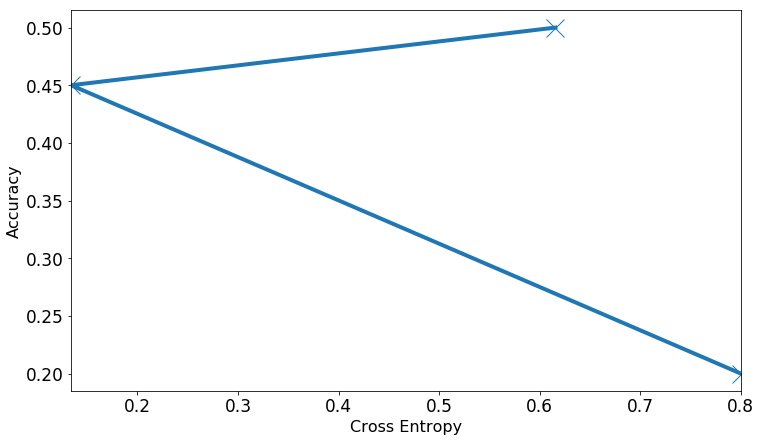

In [11]:
# Hint: not all right and wrong answers are created equally

# y_true  = 
# predictions_1 = ...
# predictions_2 = ...
# predictions_3 = ...
np.random.seed(42)
y_true  = np.random.binomial(1, 0.5, size = 20)
predictions_1 = np.random.beta(1,1, size = 20)
predictions_2 = np.random.beta(2,1, size = 20)
predictions_3 = np.random.beta(1,2, size = 20)

preds = [predictions_1, predictions_2, predictions_3]

cross_entropies = [cross_entropy(y_pred, y_true) for y_pred in preds]
accuracies = [accuracy_score(y_true, y_pred > 0.5) for y_pred in preds]
pd.Series(accuracies, index=cross_entropies).plot(
    style='-x', figsize=(12,7), fontsize=17,
    markersize=18, linewidth=4
)
plt.xlabel('Cross Entropy', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

# Problem 2: Cross Validation (10%)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

Populating the interactive namespace from numpy and matplotlib


### Part 1: Generate some data
 - Generate data with 1024 points and 10 features. 
 - Create targets that are linear combinations of the 10 features and add some noise. 
 - Split the data into train/test 80/20 percent. 

In [13]:
# Generate some data

# num_variables = ...

# x = ...
# y = ...

# x_train, x_test = ...
# y_train, y_test = ...

# del x, y  
# Generate some data

num_observations = 1024
coefs = np.array([-1.2, 5, 0, .22, 0, 2, 0, 4, 0, 0])  # notice, there are zeros!
noise_amplitude = 5

num_variables = len(coefs)
 
random.seed(7)
x = np.random.normal(loc=0.0, scale=1.0, size=(num_observations, num_variables))
y = np.dot(x, coefs) 
y = y + np.random.normal(loc=0.0, scale=0.3*np.std(y), size=num_observations) # Add some noise

x_train, x_test = x[:int(0.8*num_observations),], x[int(0.8*num_observations):,]
y_train, y_test = y[:int(0.8*num_observations),], y[int(0.8*num_observations):,]

del x, y  

### Part 2: cross validation
Here we will cross validate our data to find the best set of parameters for `Lasso` regression. We will tune the regularization strength (`alpha`) and whether we fit an intercept to the data. 
 - For each set of parameters find fit an estimator
 - Calculate the mean squared error on the test set
 - store the results (both the MSE and the parameters) so we can do analysis later

In [14]:
# alphas = # make a list of alphas here
# fit_intercepts = # make a list of the two values for `fit_intercept here`

# everything below to be removed
# for all possible combinations, compute necessary metrics
# put code here
alphas = np.arange(0, 2.1, 0.1)
fit_intercepts = [True, False]

# everything below to be removed
# for all possible combinations, compute necessary metrics
results = []

from sklearn.linear_model import Lasso 
from sklearn.metrics import r2_score, mean_squared_error
for alpha in alphas:
    for intercept in fit_intercepts:
        lassoReg = Lasso(alpha=alpha, fit_intercept=intercept)
        lassoReg.fit(x_train, y_train)
        testPred = lassoReg.predict(x_test)
        MSE = mean_squared_error(y_test, testPred)
        RSquare = r2_score(y_test, testPred)
        results.append([alpha, intercept, MSE, RSquare])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1623.1420603912552, tolerance: 4.065880348522375
  positive)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpecte

### Part 3: Analysis
 - for each value of `fit_intercept` plot the `MSE` and `r2` scores as a function of alpha. 
 - What is the overall best combination of parameters

Intercept
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

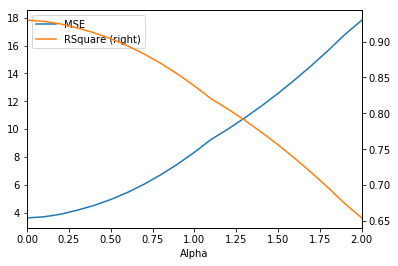

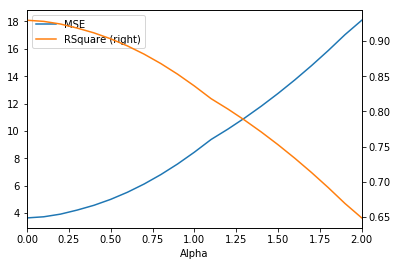

In [15]:
df = pd.DataFrame(results, columns=['Alpha', 'Intercept', 'MSE', 'RSquare']) # not needed, but maybe handy
# your plotting code here
df.groupby('Intercept').plot(x = 'Alpha', y = ['MSE', 'RSquare'], secondary_y='RSquare')

# Problem 3: Linear regression in Keras (40%)

#### We'd like to use keras to perform linear regression and compare it to another tool (scikit-learn)
#### We'll compare OLS, ridge ($L2$ regularization) and LASSO ($L1$ regularization) using both keras and scikit-learn


In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'svd', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [163]:
# Generate some data

num_observations = 1024
coefs = np.array([-1.2, 5, 0, .22, 2, 0, 4])  # notice, there are zeros!
noise_amplitude = .05

num_variables = coefs.shape[0]

x = np.random.rand(num_observations, num_variables)
y = np.dot(x, coefs) + noise_amplitude * np.random.rand(num_observations)


# your code here, 
# split data into x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = 0.3, random_state =42)

In [164]:
x_train.shape, y_train.shape

((716, 7), (716,))

In [165]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
mean_squared_error(y_test,lin_reg.predict(x_test))

0.00021885253863629132

In [166]:
# Show that the coefficients are all close the "real" ones used to generate the data
# put code here
print(corrcoef(coefs,lin_reg.coef_))
print(abs(coefs - lin_reg.coef_))

[[1.         0.99999961]
 [0.99999961 1.        ]]
[0.00116621 0.00085338 0.00027393 0.00358128 0.00222577 0.00052966
 0.00374292]


In [167]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [168]:
# Now we will use keras to solve the same problem 

from keras.models import Model, Input, Sequential
from tensorflow.keras.layers import Dense
from keras.utils import plot_model
import keras.backend as K

input_data = Input(shape=(x_train.shape[1]))
output_data = Dense(1, activation='linear')(input_data)
K.clear_session()
keras_lin_reg = Model(input_data, output_data)
keras_lin_reg.compile(optimizer='adam', loss='mse', metrics=['mse'])
keras_lin_reg.summary()
plot_model(keras_lin_reg)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## How many parameters does the model have? 
### Explicitly show the calculation, explain it, and verify that it agrees with `model.count_params()`

In [169]:
# ADD CODE HERE
print(7+1)
keras_lin_reg.count_params()

8


8

## Fit the model and calculate the MSE

In [170]:
# fit the model here
keras_lin_reg.fit(x_train, y_train, epochs = 500)

Epoch 1/500
23/23 [==============================] - 0s 673us/step - loss: 27.7842 - mse: 27.7842
Epoch 2/500
23/23 [==============================] - 0s 589us/step - loss: 26.7618 - mse: 26.7618
Epoch 3/500
23/23 [==============================] - 0s 655us/step - loss: 25.7816 - mse: 25.7816
Epoch 4/500
23/23 [==============================] - 0s 1ms/step - loss: 24.8323 - mse: 24.8323
Epoch 5/500
23/23 [==============================] - 0s 653us/step - loss: 23.9008 - mse: 23.9008
Epoch 6/500
23/23 [==============================] - 0s 602us/step - loss: 23.0110 - mse: 23.0110
Epoch 7/500
23/23 [==============================] - 0s 708us/step - loss: 22.1489 - mse: 22.1489
Epoch 8/500
23/23 [==============================] - 0s 817us/step - loss: 21.3191 - mse: 21.3191
Epoch 9/500
23/23 [==============================] - 0s 554us/step - loss: 20.5055 - mse: 20.5055
Epoch 10/500
23/23 [==============================] - 0s 643us/step - loss: 19.7344 - mse: 19.7344
Epoch 11/500
23/23 [=

In [171]:
# calculate mse
# mean_squared_error(...
mean_squared_error(y_test, keras_lin_reg.predict(x_test))

0.0005843638758131471

## get the coefficients and compare them to the real coefficients

In [172]:
# add code here
keras_coef = [i[0] for i in keras_lin_reg.get_weights()[0]]
print(np.corrcoef(coefs, keras_coef))
print(coefs - keras_coef)

[[1.         0.99999951]
 [0.99999951 1.        ]]
[0.02155285 0.02420092 0.0242757  0.02496439 0.02095211 0.02490675
 0.0285759 ]


## Now we will add some regularization

In [186]:
from keras.regularizers import l1_l2
regularizer = l1_l2(l1=0, l2=.1)
 # Dense(...) -> Dense(..., kernel_regularizer=regularizer)
    
#keras_ridge_model = Model(...

K.clear_session()
keras_ridge_model = Sequential()
keras_ridge_model.add(Dense(1, input_dim =7, kernel_regularizer=regularizer ))
keras_ridge_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [187]:
# fit the model and calculate the MSE
keras_ridge_model.fit(x_train, y_train, batch_size=1, epochs =500)

Epoch 1/500
716/716 [==============================] - 0s 527us/step - loss: 19.4483 - mse: 19.2092
Epoch 2/500
716/716 [==============================] - 0s 509us/step - loss: 7.3615 - mse: 6.8965
Epoch 3/500
716/716 [==============================] - 0s 603us/step - loss: 3.8121 - mse: 3.0966
Epoch 4/500
716/716 [==============================] - 0s 583us/step - loss: 3.0697 - mse: 2.2060
Epoch 5/500
716/716 [==============================] - 0s 573us/step - loss: 2.8712 - mse: 1.9559
Epoch 6/500
716/716 [==============================] - 0s 538us/step - loss: 2.7384 - mse: 1.7935
Epoch 7/500
716/716 [==============================] - 0s 507us/step - loss: 2.6270 - mse: 1.6503
Epoch 8/500
716/716 [==============================] - 0s 405us/step - loss: 2.5352 - mse: 1.5339
Epoch 9/500
716/716 [==============================] - 0s 507us/step - loss: 2.4655 - mse: 1.4423
Epoch 10/500
716/716 [==============================] - 0s 540us/step - loss: 2.4079 - mse: 1.3616
Epoch 11/500
716/

In [188]:
#mean_squared_error(...
mean_squared_error(y_test, keras_ridge_model.predict(x_test))

1.1194383594531445

In [189]:
# find the coefficients and compare them to the real ones
keras_ridge_coefs = [i[0] for i in keras_ridge_model.get_weights()[0]]
pd.Series(keras_ridge_coefs, name='keras ridge coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,keras ridge coefficients,real coefficients
0,-0.485400,-1.20
1,2.386765,5.00
2,-0.059723,0.00
3,0.148549,0.22
4,0.981791,2.00
5,0.050147,0.00
6,1.874310,4.00


In [190]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=100)
ridge.fit(x_train, y_train)
pd.Series(ridge.coef_, name='ridge coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,ridge coefficients,real coefficients
0,-0.392567,-1.20
1,1.973592,5.00
2,-0.062515,0.00
3,0.127622,0.22
4,0.814088,2.00
5,0.044219,0.00
6,1.547199,4.00


In [191]:
# compare coefficients from various methods
pd.concat([
    pd.Series(ridge.coef_, name='ridge coefs'),
    pd.Series(keras_ridge_coefs, name='keras L2 coefs'),
    pd.Series(coefs, name='real coefs')
], axis=1)

,ridge coefs,keras L2 coefs,real coefs
0,-0.392567,-0.485400,-1.20
1,1.973592,2.386765,5.00
2,-0.062515,-0.059723,0.00
3,0.127622,0.148549,0.22
4,0.814088,0.981791,2.00
5,0.044219,0.050147,0.00
6,1.547199,1.874310,4.00


## In fact, given the zero coefficients, LASSO might have been a better model. 
## LASSO uses $L_{1}$ regularization which will make sparse coefficients (some are zero).

In [192]:
from sklearn.linear_model import Lasso

#lasso_coefs = ...
lasso = Lasso(alpha = 0.0001)
lasso.fit(x_train, y_train)
lasso_coefs = lasso.coef_
pd.Series(lasso_coefs, name='lasso coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))

,lasso coefficients,real coefficients
0,-1.199900,-1.20
1,4.998013,5.00
2,-0.000000,0.00
3,0.215313,0.22
4,2.001154,2.00
5,-0.000000,0.00
6,3.995176,4.00


In [196]:
regularizer = l1_l2(l1=0.1, l2=0)  # to be removed

#keras_lasso_model = ...
K.clear_session()
keras_lasso_model = Sequential()
keras_lasso_model.add(Dense(1, input_dim =7, kernel_regularizer=regularizer ))
keras_lasso_model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [197]:
# fit the model and calculate the MSE
keras_lasso_model.fit(x_train, y_train, batch_size=1, epochs =200)

Epoch 1/200
716/716 [==============================] - 0s 502us/step - loss: 17.8857 - mse: 17.5273
Epoch 2/200
716/716 [==============================] - 0s 520us/step - loss: 6.9951 - mse: 6.5087
Epoch 3/200
716/716 [==============================] - 0s 557us/step - loss: 3.9878 - mse: 3.3482
Epoch 4/200
716/716 [==============================] - 0s 526us/step - loss: 3.3020 - mse: 2.5887
Epoch 5/200
716/716 [==============================] - 0s 553us/step - loss: 3.0412 - mse: 2.3052
Epoch 6/200
716/716 [==============================] - 0s 575us/step - loss: 2.8124 - mse: 2.0700
Epoch 7/200
716/716 [==============================] - 0s 557us/step - loss: 2.5877 - mse: 1.8443
Epoch 8/200
716/716 [==============================] - 0s 564us/step - loss: 2.3716 - mse: 1.6261
Epoch 9/200
716/716 [==============================] - 0s 520us/step - loss: 2.1871 - mse: 1.4367
Epoch 10/200
716/716 [==============================] - 0s 582us/step - loss: 2.0195 - mse: 1.2596
Epoch 11/200
716/

In [198]:
keras_lasso_coefs = [i[0] for i in keras_lasso_model.get_weights()[0]]
pd.Series(keras_lasso_coefs, name='keras lasso coefficients').to_frame().join(pd.Series(coefs, name='real coefficients'))
#keras_lasso_coefs = ... 

,keras lasso coefficients,real coefficients
0,-0.575506,-1.20
1,4.439364,5.00
2,-0.000468,0.00
3,-0.001649,0.22
4,1.440883,2.00
5,-0.000661,0.00
6,3.444104,4.00


In [199]:
# compare all the coefficients
pd.concat([
    pd.Series(ridge.coef_, name='ridge coefs'),
    pd.Series(keras_ridge_coefs, name='keras L2 coefs'),
    pd.Series(lasso.coef_, name='lasso coefs'),
    pd.Series(keras_lasso_coefs, name='keras L1 coefs'),
    pd.Series(lin_reg.coef_, name='ols coefs'),
    pd.Series(coefs, name='real coefs'),
], axis=1)

,ridge coefs,keras L2 coefs,lasso coefs,keras L1 coefs,ols coefs,real coefs
0,-0.392567,-0.485400,-1.199900,-0.575506,-1.201166,-1.20
1,1.973592,2.386765,4.998013,4.439364,4.999147,5.00
2,-0.062515,-0.059723,-0.000000,-0.000468,-0.000274,0.00
3,0.127622,0.148549,0.215313,-0.001649,0.216419,0.22
4,0.814088,0.981791,2.001154,1.440883,2.002226,2.00
5,0.044219,0.050147,-0.000000,-0.000661,-0.000530,0.00
6,1.547199,1.874310,3.995176,3.444104,3.996257,4.00


## Comment on the results

In [183]:
# Safe to restart here

Lasso & OLS product coefs that are closer to the real coefs. Lasso pushes some of the betas (beta 2 and 5) to zero as expected.

Comparing the 1st with the 2nd column and the 3rd with the 4th column, we see that the results generated by Keras and Scikit Learn are different but close. The results might get closer if we further tune the batch_size and number of epochs. Keras is more flexible and focus on neural network. Scikit Learn is a more general machine learning and easier to use.


# Problem 4: Custom Loss Functions (10%)
### In this problem we will explore the use of custom loss function to better capture desired behavior in a model.
### In particular, we will examine the tradeoff between false positives and true positives

In [200]:
# safe to restart here

In [253]:
import numpy as np
import pandas as pd
%pylab inline

# many of these to be removed
# Insert necessary imports here

Populating the interactive namespace from numpy and matplotlib


## Part 0: Data preparation
 - ### Load the `mnist` data and subset the data only to the classes `4` and `9`
 - ### This way we have a binary classification task for simplicity

In [254]:
from keras.utils import to_categorical
from keras.datasets import mnist

def preprocess_training_data(data):
    data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    data = data.astype('float32') / 255
    return data

def preprocess_targets(target, num_classes):
    return to_categorical(target, num_classes)

def subset_to_9_and_4(x, y):  # this is a new function
    # insert code here:
    # new_x should be x where y is either 4 or 9
    # new_y should be true if y == 4 and False is y = 9
    new_x = []
    new_y = []
    for i in range(len(x)):
        if y[i] == 4: 
            new_y.append(True)
            new_x.append(x[i])
        if y[i] == 9: 
            new_y.append(False)
            new_x.append(x[i])
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    
    return new_x, new_y

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess_training_data(x_train)
x_test = preprocess_training_data(x_test)

num_classes = np.unique(y_train).shape[0]

y_train_ohe = preprocess_targets(y_train, num_classes)
y_test_ohe = preprocess_targets(y_test, num_classes)

x_train, y_train = subset_to_9_and_4(x_train, y_train)
x_test, y_test = subset_to_9_and_4(x_test, y_test)

print(x_train.shape)

(11791, 784)


## Part 1: fit logistic regression in `scikit-learn` and compute the true positive and false positive rates

In [255]:
%%time
# insert code here
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1e+03 ms, sys: 54.4 ms, total: 1.05 s
Wall time: 1.08 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [256]:
# put your code here
preds = log.predict(x_test)
tp = preds & y_test
fp = preds & ~y_test
tn = ~preds & ~y_test
fn = ~preds & y_test

tpr =  tp.sum()/(tp.sum()+fn.sum())
fpr =  fp.sum()/(fp.sum()+tn.sum())
fnr =  fn.sum()/(tp.sum()+fn.sum())

print('false positive rate {:.3f}'.format(fpr))
print('false negative rate {:.3f}'.format(fnr))


false positive rate 0.030
false negative rate 0.026


In [205]:
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(log, x_test, y_test, normalize = 'true')

## Part 2: A custom loss function
### Write a function that returns a custom loss function
### As a shortcut, we can modify the loss function to be
### $J(\theta )$=`regular crossentropy `  $\times$  $\alpha$ 

### where 
 - ### $\alpha=$ 1 + `weight_factor` (a number greater than 0) for the positive class (`y=1`)
 - ### $\alpha=$ `1` for the negative class (`y=0`)

### Like this we can over weight how much we care about positive examples. 

# $ \\ $
## Function
### Inputs:
 - ### `weight_factor`: the multiplicative factor for how much to weight errors in the `1` class over `0`

### Output:
 - ### a function that has inputs `(y_true, y_pred)` that is a viable keras loss function. 


In [266]:
import tensorflow as tf
from keras.objectives import binary_crossentropy

def get_loss_function(weight_factor):
    num_datapoints = y_train.shape[0]
    def my_cross_entropy(y_true, y_pred):
        #insert code here
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        weighted  = binary_crossentropy(y_true, y_pred)*(1+y_true*weight_factor)
        return K.mean(weighted)
    return my_cross_entropy

## Part 3: Fit Models with Different `weight_factors`
## Steps
 - ### For values in `np.linspace(0, 20, 50)` fit logistic regression in keras.
 - ### For each model compute the true positive and false positive rate
 - ### Make a plot of true positives and false positives as a function of `weight_factor`
 - ### Make a plot of true positives as a function of false positives

In [271]:
from sklearn.metrics import confusion_matrix
res = {}
WT = []
Tpr = []
Fpr = []

for wt in np.linspace(0, 20, 50):
    K.clear_session()
    digit_input = Input(shape=(x_train.shape[1],), name='digit_input')
    output = Dense(1, activation='sigmoid')(digit_input) # linear activation leads to very zigzag performance
   
    # After trying different activation, sigmoid yield relative smooth prediction
    model = Model(digit_input, output)
    model.compile(optimizer='adam', loss = get_loss_function(wt), metrics=['accuracy'])
    model.fit(x_train, y_train)
    
    # calculate metrics here and save them in `res`
    y_pred = model.predict(x_test).squeeze()
    y_pred = (y_pred > 0.5).astype(int)
    y_test = (y_test > 0.5).astype(int)
    
    tp = y_pred & y_test
    fp = y_pred & (1-y_test)
    tn = (1-y_pred) & (1-y_test)
    fn = (1-y_pred) & y_test

    tpr =  tp.sum()/(tp.sum()+fn.sum())
    fpr =  fp.sum()/(fp.sum()+tn.sum())

    WT.append(wt)
    Tpr.append(tpr)
    Fpr.append(fpr)

369/369 [==============================] - 0s 809us/step - loss: 4.1983 - accuracy: 0.8698


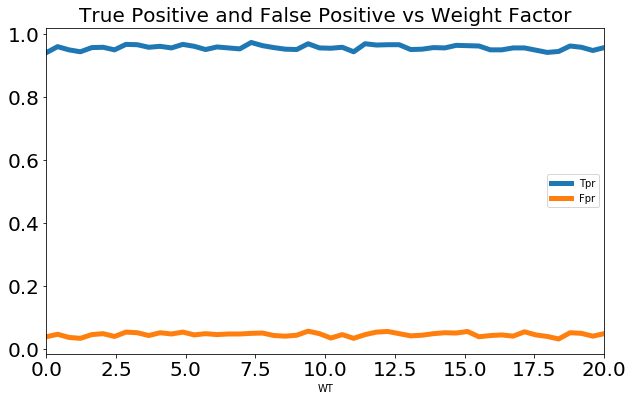

In [272]:
# put plotting code here
# true positive and false positives as a function of wt

res = {"WT":WT, "Tpr": Tpr, "Fpr": Fpr}
df = pd.DataFrame(res)
df.set_index("WT", inplace=True)
df['Tpr'].plot(figsize=(10,6), linewidth=5, markersize=12, fontsize=20)
df['Fpr'].plot(figsize=(10,6), linewidth=5, markersize=12, fontsize=20)
plt.title('True Positive and False Positive vs Weight Factor', fontsize=20)
plt.legend()
plt.show()

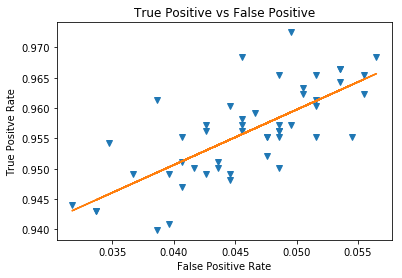

In [273]:
# true positives as a function of false positives
import matplotlib.pyplot as plt

x = np.array(df['Fpr'])
y = np.array(df["Tpr"])
m, b = np.polyfit(x, y, 1)
plt.plot(df['Fpr'], df["Tpr"], 'v')
plt.title('True Positive vs False Positive')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.plot(x, m*x+b)
plt.rcParams["figure.figsize"] = (15,8)
plt.show()

## Part 4: Thresholding vs Loss Function
### What is the difference between using regular crossentropy and changing thresholds vs changing the loss function? 
### Typically, we consider anything with a predicted probability of 0.5 or above to be a positive example. What if we change this number?

## Steps:
 - ### Fit logistic regression in keras with the regular (crossentropy) loss function
 - ### Find the false positive and true positive rates as a function of the `threshold` for which we consider a positive example. 
 - ### Make a plot of false positives as a function of true positives for this thresholding method.
 - ### On the same axes, plot the old curve of false positives as a function of true positives
 - ### Comment on what you find- what are the advantages and disadvantages of these two methods.

In [274]:
#regular cross entropy
def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    num_datapoints = predictions.shape[0]
    ce = -1 * np.sum(targets*np.log(predictions + 1e-9)) / num_datapoints
    return ce

In [275]:
K.clear_session()
digit_input = Input(shape=(x_train.shape[1],), name='digit_input')
output = Dense(1, activation='sigmoid')(digit_input)
model = Model(inputs=digit_input, outputs=output)
model.compile(optimizer = 'rmsprop', loss = "binary_crossentropy")        
model.fit(x_train, y_train, batch_size=1, epochs=5, shuffle=False)
# your code goes here

Epoch 1/5
11791/11791 [==============================] - 7s 574us/step - loss: 0.1624
Epoch 2/5
11791/11791 [==============================] - 6s 544us/step - loss: 0.1250
Epoch 3/5
11791/11791 [==============================] - 6s 525us/step - loss: 0.1288
Epoch 4/5
11791/11791 [==============================] - 6s 517us/step - loss: 0.1329
Epoch 5/5
11791/11791 [==============================] - 6s 526us/step - loss: 0.1366


In [276]:
pred_proba = model.predict(x_test).squeeze()
print(pred_proba)

[9.9604511e-01 9.9999976e-01 1.6283989e-04 ... 1.0000000e+00 2.8246343e-03
 9.8844737e-01]


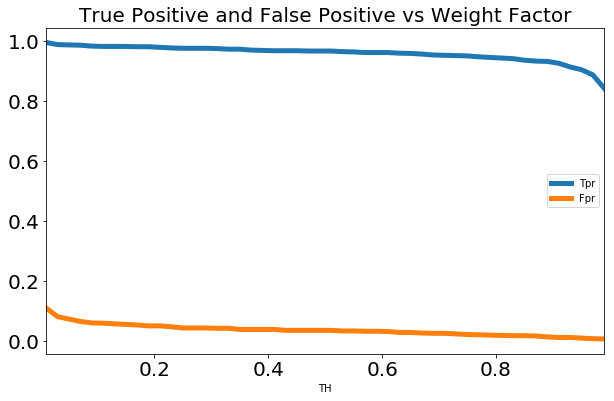

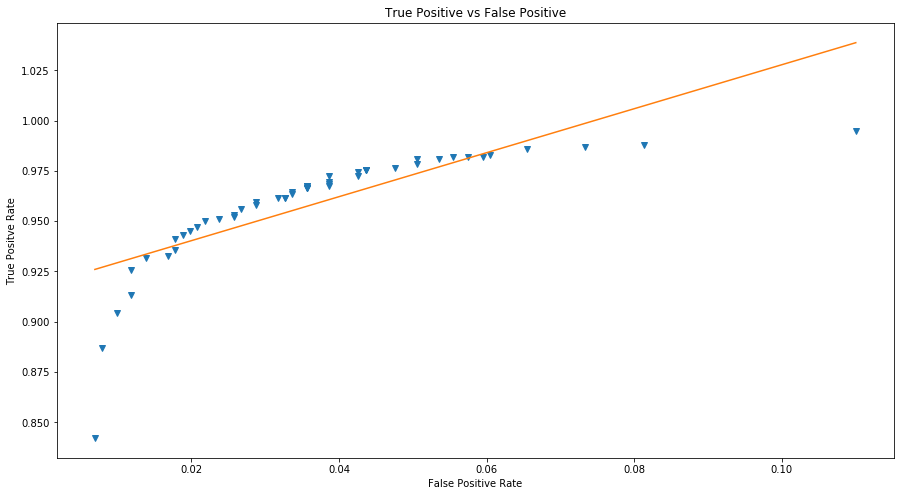

In [214]:
# your code here
res_th = {}
Thre = []
Tpr_th = []
Fpr_th = []

for thre in np.linspace(0.01, 0.99, 50):
    y_pred = pred_proba
    y_pred = (y_pred > thre).astype(int)
    y_test = (y_test > thre).astype(int)
    
    tp = y_pred & y_test
    fp = y_pred & (1-y_test)
    tn = (1-y_pred) & (1-y_test)
    fn = (1-y_pred) & y_test

    tpr =  tp.sum()/(tp.sum()+fn.sum())
    fpr =  fp.sum()/(fp.sum()+tn.sum())

    Thre.append(thre)
    Tpr_th.append(tpr)
    Fpr_th.append(fpr)

res_th = {"TH":Thre, "Tpr": Tpr_th, "Fpr": Fpr_th}
df_th = pd.DataFrame(res_th)
df_th.set_index("TH", inplace=True)
df_th['Tpr'].plot(figsize=(10,6), linewidth=5, markersize=12, fontsize=20)
df_th['Fpr'].plot(figsize=(10,6), linewidth=5, markersize=12, fontsize=20)
plt.title('True Positive and False Positive vs Weight Factor', fontsize=20)
plt.legend()
plt.show()

x2 = np.array(df_th['Fpr'])
y2 = np.array(df_th["Tpr"])
m2, b2 = np.polyfit(x2, y2, 1)
plt.plot(df_th['Fpr'], df_th["Tpr"], 'v')
plt.title('True Positive vs False Positive')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.plot(x2, m2*x2+b2)
plt.rcParams["figure.figsize"] = (15,8)
plt.show()

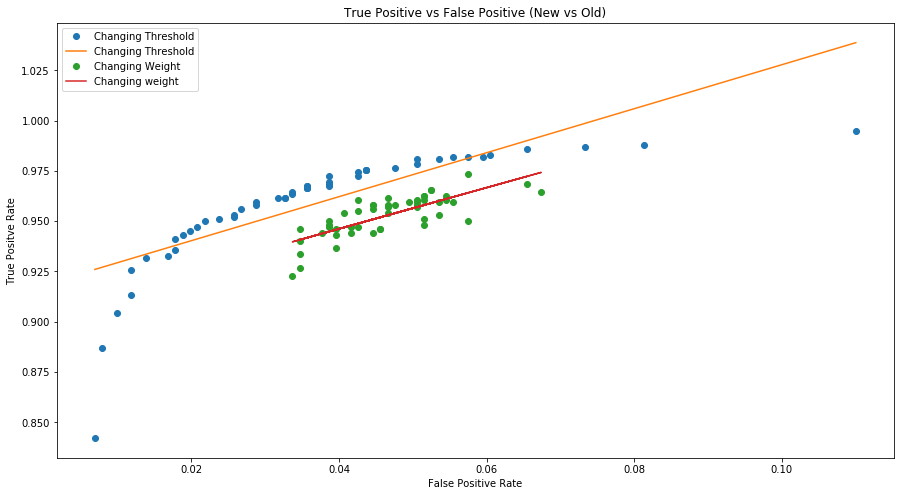

In [226]:
x2 = np.array(df_th['Fpr'])
y2 = np.array(df_th["Tpr"])
m2, b2 = np.polyfit(x2, y2, 1)
plt.plot(df_th['Fpr'], df_th["Tpr"], 'o')
plt.title('True Positive vs False Positive (New vs Old)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.plot(x2, m2*x2+b2)
plt.plot(df['Fpr'], df["Tpr"], 'o')
plt.plot(x, m*x+b)
plt.legend(["Changing Threshold", "Changing Threshold", "Changing Weight", "Changing weight"])
plt.rcParams["figure.figsize"] = (15,8)
plt.show()

In [227]:
# comments here

TP/FP rates are more sensitive to the changes in threshold. Results by changing threshold are above the results by changing weights, so changing threshold performs better than changing weights.

In [228]:
# safe to restart

# Problem 5: Custom Regularization (15%)

In [229]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%pylab inline

# many of these to be removed
# necessary imports here

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [230]:
np.random.seed(1234)
n_points = 2048

x = np.vstack([np.random.randn(n_points) + ii for ii in np.arange(-3, 3)]).T
real_coefs = np.array([1.4, 0.9, .1, -3, 2.2, -1.3])
y = x.dot(real_coefs) + .5 * np.random.randn(n_points)

In [231]:
x.shape

(2048, 6)

Text(0, 0.5, 'counts')

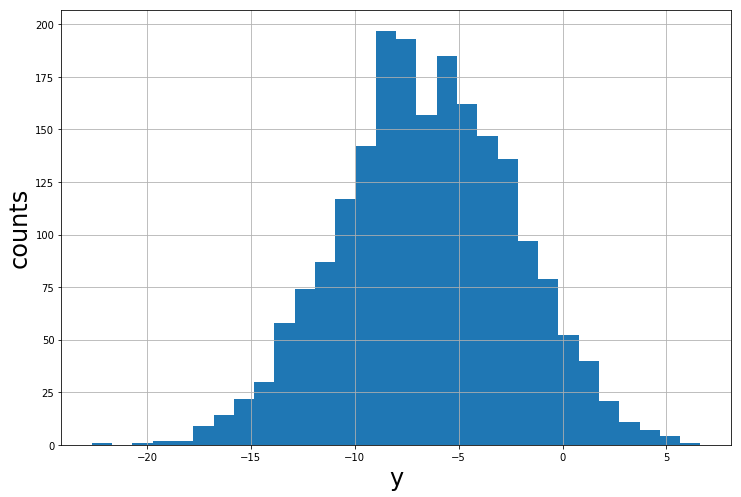

In [232]:
pd.Series(y).hist(bins=30, figsize=(12,8))
plt.xlabel('y', fontsize=24)
plt.ylabel('counts', fontsize=24)

## A new regularization
Sometimes, in the social science and in low-data situations a good rule of thumb is that instead of doing linear regression to find the coefficients, we can assume that all the coefficients are the same!

We will implement a variation on this by penalizing the `variance` of the coefficients, instead of the size.

__NOTE__: this is not a good thing to do in this situation- we have coefficients of different sign!

In this problem we will first solve linear regression with keras. Then we will add a custom regularizer to penalize the variance, and see what the effect are. 

# $ \\ $
# $ \\ $
## Part 0: Solve the problem with no regularization
### Steps:
 - ### Partition the data into train/test
 - ### Fit linear regression in keras with no regularization
 - ### Find the `mse` for the test set this model
 - ### Examine the coefficients and make sure they look correct

In [233]:
# partition the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =42)

In [234]:
# fit the data 
K.clear_session()
input_data = Input(shape=(x_train.shape[1],), name='input_data')
output = Dense(1, activation='linear')(input_data)

model = Model(input_data, outputs=output)
model.compile(optimizer = 'adam', loss = "MSE")
model.fit(x_train, y_train, batch_size=1, epochs=200)

Epoch 1/200
1433/1433 [==============================] - 1s 487us/step - loss: 22.3074
Epoch 2/200
1433/1433 [==============================] - 1s 531us/step - loss: 10.2743
Epoch 3/200
1433/1433 [==============================] - 1s 530us/step - loss: 6.2014
Epoch 4/200
1433/1433 [==============================] - 1s 475us/step - loss: 3.4169
Epoch 5/200
1433/1433 [==============================] - 1s 479us/step - loss: 1.7105
Epoch 6/200
1433/1433 [==============================] - 1s 486us/step - loss: 0.7963
Epoch 7/200
1433/1433 [==============================] - 1s 427us/step - loss: 0.4089
Epoch 8/200
1433/1433 [==============================] - 1s 449us/step - loss: 0.2922
Epoch 9/200
1433/1433 [==============================] - 1s 360us/step - loss: 0.2687
Epoch 10/200
1433/1433 [==============================] - 1s 356us/step - loss: 0.2640
Epoch 11/200
1433/1433 [==============================] - 1s 363us/step - loss: 0.2605
Epoch 12/200
1433/1433 [==========================

In [235]:
from sklearn.metrics import mean_squared_error
# calculate MSE
y_pred = model.predict(x_test)
mean_squared_error(y_test, y_pred)

0.26444832946720154

In [236]:
# examine coefs and make sure they look right
print(model.get_weights()[0].squeeze())
print(real_coefs)

[ 1.4100591   0.9053834   0.08730446 -2.9861474   2.2013392  -1.3001726 ]
[ 1.4  0.9  0.1 -3.   2.2 -1.3]


### We can see that thet are pretty close to the real coefficient

## Part 1: Add Regularization
## Steps:
 - ### Make a function that given a `weight_factor` returns a well-formed keras regularization function that penalizes the variance of coefficients by this factor. 
 - ### Fit a model with this regularizer with a `weight_factor` of `1.0`. 
 - ### Calculate the `mse` on the test set and examine the coefficients. 

__Note__: the coefficients should be closer together. Are they?


In [237]:
def make_reg_function(wt_factor):
    def my_reg(weight_matrix):
        # your code here
        return wt_factor * K.var(weight_matrix)
    return my_reg


In [238]:
K.clear_session()
# make and fit a model

inputs = Input(shape=(x_train.shape[1],))
output = Dense(1, activation='linear',kernel_regularizer=make_reg_function(1.0))(inputs)

model2 = Model(inputs, outputs=output)
model2.compile(optimizer = 'adam', loss = 'MSE')
model2.fit(x_train, y_train, batch_size=1, epochs=200)

Epoch 1/200
1433/1433 [==============================] - 1s 528us/step - loss: 27.4798
Epoch 2/200
1433/1433 [==============================] - 1s 567us/step - loss: 10.8132
Epoch 3/200
1433/1433 [==============================] - 1s 525us/step - loss: 7.2277
Epoch 4/200
1433/1433 [==============================] - 1s 505us/step - loss: 5.0327
Epoch 5/200
1433/1433 [==============================] - 1s 518us/step - loss: 3.7600
Epoch 6/200
1433/1433 [==============================] - 1s 563us/step - loss: 3.1521
Epoch 7/200
1433/1433 [==============================] - 1s 484us/step - loss: 2.9185
Epoch 8/200
1433/1433 [==============================] - 1s 444us/step - loss: 2.8510
Epoch 9/200
1433/1433 [==============================] - 1s 393us/step - loss: 2.8353
Epoch 10/200
1433/1433 [==============================] - 1s 411us/step - loss: 2.8339
Epoch 11/200
1433/1433 [==============================] - 1s 413us/step - loss: 2.8323
Epoch 12/200
1433/1433 [==========================

In [240]:
# examine coefs
print(model2.get_weights()[0].squeeze())
print(real_coefs)

[ 1.2015716   0.7840879   0.10083921 -2.5192776   1.8937423  -1.0827874 ]
[ 1.4  0.9  0.1 -3.   2.2 -1.3]


In [241]:
# calculate MSE
y_pred = model2.predict(x_test)
mean_squared_error(y_test.squeeze(), y_pred)

0.6926443615137953

## Part 2: Turn up the Regularization
## Steps
 - ### Repeat part 1 with the weight factor turned up to many times its initial value
 - ### Calculate the `mse` on the test set
 - ### examine the coefficients and comment
 - ### compare these results to the best constant guess for `y`.

In [243]:
K.clear_session()
# make and fit a model with MUCH more regularization

inputs = Input(shape=(x_train.shape[1],))
output = Dense(1, activation='linear',kernel_regularizer=make_reg_function(10.0))(inputs)

Reg_turnedup = Model(inputs, outputs=output)
Reg_turnedup.compile(optimizer = 'adam', loss = 'MSE')
Reg_turnedup.fit(x_train, y_train, batch_size=1, epochs=200)

Epoch 1/200
1433/1433 [==============================] - 1s 528us/step - loss: 65.3315
Epoch 2/200
1433/1433 [==============================] - 1s 492us/step - loss: 17.4028
Epoch 3/200
1433/1433 [==============================] - 1s 537us/step - loss: 13.4864
Epoch 4/200
1433/1433 [==============================] - 1s 529us/step - loss: 12.4537
Epoch 5/200
1433/1433 [==============================] - 1s 528us/step - loss: 12.0579
Epoch 6/200
1433/1433 [==============================] - 1s 446us/step - loss: 11.9021
Epoch 7/200
1433/1433 [==============================] - 1s 453us/step - loss: 11.8037
Epoch 8/200
1433/1433 [==============================] - 1s 485us/step - loss: 11.7441
Epoch 9/200
1433/1433 [==============================] - 1s 431us/step - loss: 11.6788
Epoch 10/200
1433/1433 [==============================] - 1s 472us/step - loss: 11.6381
Epoch 11/200
1433/1433 [==============================] - 1s 466us/step - loss: 11.6032
Epoch 12/200
1433/1433 [=================

In [244]:
# look at the coefs
print(Reg_turnedup.get_weights()[0].squeeze())
print(real_coefs)

[ 0.5373534   0.3813232   0.11155561 -1.0217155   0.8700546  -0.3863255 ]
[ 1.4  0.9  0.1 -3.   2.2 -1.3]


In [246]:
# calculate MSE
y_pred = Reg_turnedup.predict(x_test)
mean_squared_error(y_test.squeeze(), y_pred)

7.74338450179633

## This is not bad.
 - What would the MSE of the best CONSTANT guess for `y`?

In [247]:
# your code here
mean_squared_error(y_test, [y_test.mean()]*y_test.shape[0])

18.26199144900479

## Comments


Penalizing the parameter variance is not a good idea since mse of no regularization < mse of small penalization (with initial weight_factor) < mse of larger penalization (with larger weight_factor).